# 목적
* 크롤링 결과로 네트워크분석
* [참고](https://foreverhappiness.me/38)


# 선행설치

In [1]:
# 선행설치
# # 크롤링
# !pip install beautifulsoup4
# !pip install requests
# !pip install lxm
# # 연관분석
# !pip install apyori
# # 자연어처리
# !pip install konlpy (JDK 설치가 되어있어야함 )
# # 워드클라우드
# !pip install wordcloud

In [30]:
# import
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook  # 진행과정 시각화
from datetime import timedelta  # 시간날짜
from apyori import apriori  # 연관분석

import re
import json
import math
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np

import requests
import urllib.request
import urllib.error
import urllib.parse
from bs4 import BeautifulSoup  # 크롤링

from PIL import Image
import numpy as np
import wordcloud
import random

import konlpy
from konlpy.tag import Komoran,Kkma,Okt,Twitter  # 자연어처리
# from eunjeon import Mecab #은전한닢 mecab을 설치하면 먹통이됨 2020-04-10 10:10:10 작동안됨
# import MeCab # meacb 별도설치 2020-04-10 10:10:10 작동안됨
import kss

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# mecab = Mecab()
okt = Okt()
komoran = Komoran(userdic='./user_dictionary.txt')

#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important; }</style>'))

# 네이버 검색 URl구조

date_from - YYYYMMDD : 시작날짜 date_option 8일때   
date_option - int : 0 : 전체, 2 : 1일, 3 : 1주, 4 : 1개월, 6 : 6개월, 7 : 1년, 8 : 기간지정  
date_to - YYYYMMDD : 마지막날짜 date_option 8일때  
dup_remove - int : 유사문서제거옵션 1 : 제거, 0 : 유지  
nso - str : _상세검색으로 추정_   
post_blogurl - ?  
post_blogurl_without - ?   
query - str : 검색어     
sm=tab_pge -?    
st - str : 정렬순서 sim : 유사도 date : 날짜    

In [3]:
# #네이버에서 검색했을때 url구조
# https://search.naver.com/search.naver
#     ?date_from=&
#     date_option=0&
#     date_to=&
#     dup_remove=1&
#     nso=&
#     post_blogurl=
#     &post_blogurl_without=
#     &query=%EC%96%91%EC%96%91
#     &sm=tab_pge
#     &srchby=all
#     &st=sim
#     &where=post
#     &start=11

In [4]:
def del_outword(string):
    '''
    이모티콘, \u200b과 같은 문자가 아닌 것 제거
    #이모티콘 제거 [출처](https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python)
    '''
    #이모지제거
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

    #분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
    han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~"^_\n\r#\ufeff\u200d\u200b\u7643\ufffd\u682e\u62c4]+')
    
    string = emoji_pattern.sub(r'',string)
    string = han.sub(r'',string)
    
    return string

In [5]:
def time_change(x):
    '''
    검색결과에 있는 문자를 날짜로 변경
    '''
    min_pattern = re.compile('[0-9]+'+"분 전")
    hour_pattern = re.compile('[0-9]+'+"시간 전")
    day_pattern = re.compile('[0-9]+'+"일 전")

    today = datetime.datetime.today().date()
    # 일자
    try:
        d = re.findall(day_pattern, x)[0][0]
        x = today - timedelta(days=int(d))
    except:
        pass
    # 시간
    try:
        d = re.findall(hour_pattern, x)[0]
        x = today
    except:
        pass
    # 분
    try:
        h = re.findall(min_pattern, x)[0]
        x = today
    except:
        pass

    if x == '어제':
        x = today - timedelta(days=1)

    elif type(x) == str:
        x = datetime.datetime.strptime(x.replace('.', '-')[:-1], '%Y-%m-%d')
    #모든일자를 1일로 통일
    x = datetime.datetime.strptime(x.strftime('%Y-%m')+"-01","%Y-%m-%d")
    return x

In [6]:
def naver_blog_crawling(keyword, start_num=1, end_num=101, date_option=0, date_from='', date_to='', save=True):
    '''
    네이버 블로그 크롤링 함수
    네이버 블로그 검색결과를 크롤링하며, 1페이지당 10개씩을 검색한다

    keyword : string
     검색하고 싶은 키워드를 넣는다
     "keyword +필수어" 형태로 필수단어 추가 가능
    start_num : int (default = 1) 
     시작할 위치 1로 끝나는 단위 추천
    end_num : int (default = 101)
     끝나는 위치 1로 끝나는 단위 추천
    date_option : int (default = 0)
     주어지는 숫자에 의해 검색방법이 변경됨
     0 : 전체, 2 : 1일, 3 : 1주, 4 : 1개월, 6 : 6개월, 7 : 1년, 8 : 기간지정
    date_from : YYYYMMDD (default = "")
     date_option이 8일때 사용 검색 시작일자를 지정
    date_to : YYYMMDD (default = "")
     date_option이 8일때 사용 검색 마지막일자를 지정
    save : bool (default = True)
     csv로 저장 여부 결정
    '''
    # url 찾는 패턴
    pattern = re.compile('href="'+'[A-z0-9\:\/\&\;\.\?\=]+')

    # 저장위치
    postdates = []
    strings = []
    urls = []
    titles = []
    output_error = []
    connection_error = []
    count = 1
    base_url_ls = []

    # keyword와 시작넘버만 바꾸면서 진행하게끔
    base_url = 'https://search.naver.com/search.naver?date_from={date_from}&date_option={date_option}&date_to={date_to}&dup_remove=1&nso=&post_blogurl=&post_blogurl_without=&query={keyword}&sm=tab_pge&srchby=all&st=sim&where=post&start={start}'

    # for문 돌려야하는 부분(각 검색결과의 시작은 1이고, 10개씩 보여짐,)
    for i in tqdm_notebook(range(start_num, end_num+1, 10), desc="page work"):
        search_list = base_url.format(keyword=keyword, start=i,
                                      date_option=date_option, date_from=date_from, date_to=date_to)
        response = requests.get(search_list)
        base_url_ls.append(search_list)
        if response.status_code is 200:
            # 1번 검색시 10개의 결과가 출력 따라서 section은 총 10개
            soup = BeautifulSoup(response.content, 'lxml')
            sections = soup.findAll('li', attrs={'class': 'sh_blog_top'})

            for section in sections:
                try:
                    # href부분만 가져오기 어려워서 정규표현식으로 검색
                    url = re.findall(pattern, str(section))[0].replace(
                        '?Redirect=Log&amp;logNo=', '/').replace('href="', '')
                    title = section.select_one('a.txt84').text
                    date = section.select_one('dd.txt_inline').text.strip()

                    # 블로그 url안에 들어가기(아직 크롤링불가)
                    get_blog_post_content_code = requests.get(url)
                    get_blog_post_content_text = get_blog_post_content_code.text
                    get_blog_post_content_soup = BeautifulSoup(
                        get_blog_post_content_text, 'lxml')

                    # 크롤링가능한 url에 접속
                    real_blog_post_url = "http://blog.naver.com" + \
                        get_blog_post_content_soup.select('#mainFrame')[
                            0].get('src')
                    get_real_blog_post_content_code = requests.get(
                        real_blog_post_url)
                    get_real_blog_post_content_text = get_real_blog_post_content_code.text
                    get_real_blog_post_content_soup = BeautifulSoup(
                        get_real_blog_post_content_text, 'lxml')

                    # url (에러나면 위에서부터 에러남)
                    urls.append(real_blog_post_url)
                    # 블로그명
                    titles.append(title)
                    # 날짜
                    postdates.append(date)

                    # 본문  (postviewarea 패턴과 se-main-container 2가지 유형이 있어 분리함)
                    try:
                        blog_post_content = get_real_blog_post_content_soup.select(
                            'div#postViewArea')
                        if len(blog_post_content) == 0:
                            blog_post_content = get_real_blog_post_content_soup.select(
                                'div.se-main-container')
                            if len(blog_post_content) == 0:
                                blog_post_content = get_real_blog_post_content_soup.select(
                                    'div.se_component_wrap.sect_dsc.__se_component_area')

                        string = ""
                        for sentence in blog_post_content[0].stripped_strings:
                            string += " "+sentence.replace('\xa0', " ")
                            # 비언어 텍스트제거
                            string = del_outword(string)
                        #공백에러대처
                        blank_check = string.replace(" ","")
                        if len(blank_check) == 0:
                            strings.append(["X"])
                        else : 
                            strings.append([string])
                        count += 1
                    except:
                        strings.append(["X"])
                        count += 1

                except Exception as ex:
                    # print('가져오기에러 {num}번째'.format(num = count),ex)
                    output_error.append(count)
                    count += 1
                    pass
        else:
            # print('연결오류 {num}번째'.format(num = count),response.status_code)
            connection_error.append(count)
            count += 1

    out_length = len(output_error+connection_error)
    real_length = end_num-start_num+10-out_length
    crawling_df = pd.DataFrame(
        {"post_dates": postdates, "title": titles, "full_text": strings, "url": urls})
    crawling_df['post_dates'] = crawling_df['post_dates'].apply(
        lambda x: time_change(x))

    # 중복제거
    crawling_df.drop_duplicates("url", inplace=True)
    crawling_df.reset_index(drop=True, inplace=True)
    real_length = crawling_df.shape[0]

    # 결과출력
    print("검색한 길이:", end_num-start_num+10)
    print("제외된 길이:", out_length)
    print("검색된 길이:", real_length)
    if save == True:
        today = datetime.datetime.today().date()
        str(today)
        crawling_df.to_csv(str(today)+"_"+keyword+"_" +
                           str(real_length)+'.csv', encoding='utf-8', index=False)
#     return strings, urls, postdates
    return crawling_df, output_error, real_length

### 크롤링된 데이터가지고 진행

In [21]:
# keyword검색시 "검색어 +필수어" 형태로 필수단어 삽입가능
today = datetime.datetime.today().date()
keyword = "양양 +강원도"
start_num = 1
end_num = 701
date_option = 8
date_from = "20150101"
date_to = "20151231"

In [257]:
#불용어
sw = list(set(['오늘', '시간', '최근', '지난', '관련', '이번', '이날', '현재', '10', '올해', '지난해', '있다', '이상', '기준', '때문',
               '메뉴', '강원도', '정도', '도착', '생각', '사진', '위치', '라고','아침', '저녁', '다음', '우리', '시작', '여기', '이곳', '사람',
               '여행','바다','해변','다시','역시','하루','이용','하나','준비','정말','바로','저희','한번','모습','마음','보고','아주','그냥','처음',
               '지도','보기','상세','전화','저장', '폴더', '가기','장소','팝업','레이스',"진짜","조금","위해",'모두',"어떻다","이제","출발",
              '이다', '많다','좋다','같다','없다','그렇다','이렇다','아니다','안녕하다','가능하다',
              "모두","가장","소개","추천","다른","방문","주변","자리","지금","포스팅","느낌",
            "지역","가지","직접","사용","입구","어떻다","날씨","타고","출발","이제","이다","사실",'가면','주문','근처',
              "양양군","양양"]))

In [341]:
# crawling_df, output_error, real_length = naver_blog_crawling(keyword, start_num, end_num, date_option, date_from, date_to, save=False)

# 데이터로드
crawling_df = pd.read_csv('./output/20일 중복x 21일 중복o 비교/크롤링/2020-04-21_양양 +강원도_811_20150101~20151231.csv')

In [342]:
crawling_df.head()

,post_dates,title,full_text,url
0,2015-06-01,쩡아네,[' 주말에 선우맘은 형님네랑 강원도 양양에 다녀왔어요 완전 맛있는 치킨 피자집을 ...,http://blog.naver.com/PostView.nhn?blogId=sin8...
1,2015-04-01,뭉가무자치의 캠핑여행,[' 뭉가무자치의 캠핑여행 자연휴양림 시설중에서 볼거리가 많은 모습이다. 산림문화...,http://blog.naver.com/PostView.nhn?blogId=sysz...
2,2015-01-01,지순이아범,[' [강원도 숙소]낙산 톡게스트하우스 속초/양양 강원도 양양 낙산 톡게스트하우스 ...,http://blog.naver.com/PostView.nhn?blogId=gv18...
3,2015-06-01,내가 행복한 이유,[' 강원도 양양 맛집 실로암 메밀국수에 또 다녀왔습니다. 너무 유명해서... 찾기...,http://blog.naver.com/PostView.nhn?blogId=neln...
4,2015-10-01,5479xodid님의블로그,[' 양양 강원도 기간 : 2015.10.03 2015.10.04 (1박 2일) ...,http://blog.naver.com/PostView.nhn?blogId=5479...


### 추출된 데이터 일자별 집중도 확인

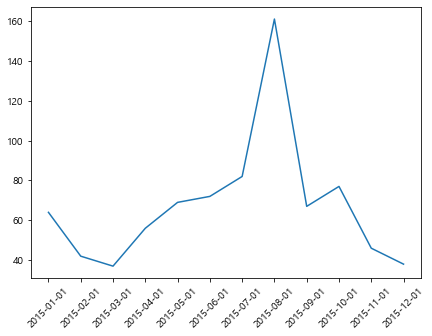

In [343]:
plt.figure(figsize=(7,5))
plt.plot(crawling_df['post_dates'].value_counts().sort_index())
plt.xticks(rotation = 45)
# plt.savefig("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_날짜빈도'+'.png')
plt.show()

In [344]:
target = crawling_df['full_text']
tagger = okt
unique = False
save = True

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

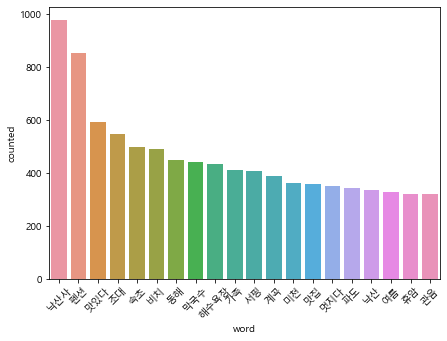

In [345]:
all_words =[]

for blog_num in tqdm_notebook(range(0,len(crawling_df))):
    #블로그 품사태깅 (load한 경우 list가 아닌 text로 받아서 첫번째가 아닌 전체를 받는다)
#     pos_text = okt.pos(target[blog_num][0], norm=True, stem=True)
    pos_text = okt.pos(target[blog_num], norm=True, stem=True)
    
    pos_text_df = pd.DataFrame(pos_text)
    words = pos_text_df[pos_text_df[1].apply(lambda x : (x in "Noun") | (x in "Adjective"))][0].values
    clean_words = list(filter(lambda word : (len(word)>1)&(word not in sw),words))
    
    if unique == True:
        clean_words = list(set(clean_words))
    all_words.append(clean_words)

#2중리스트 flatten
all_word_flatten = [y for x in all_words for y in x]

count_df = pd.Series(all_word_flatten).value_counts().reset_index()

count_df.columns = ['word','counted']
#그래프
plt.figure(figsize=(7,5))
sns.barplot(x= 'word', y = 'counted', data = count_df.head(20))
plt.xticks(rotation = 45)

### 예제

In [346]:
#DTM
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'you know I want your love',
    'I like you',
    'what should I do ',    
]
vector = CountVectorizer()
values = vector.fit_transform(corpus).toarray() # 코퍼스로부터 각 단어의 빈도 수를 기록한다.
cols = vector.vocabulary_.keys() # 각 단어의 인덱스가 어떻게 부여되었는지를 보여준다.
DTM_df = pd.DataFrame(values,columns= cols)

In [347]:
#TF_IDF
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'you know I want your love',
    'I like you',
    'what should I do ',    
]
tfidfv = TfidfVectorizer().fit(corpus)
values = tfidfv.transform(corpus).toarray()
cols = tfidfv.vocabulary_.keys()

TF_IDF_df = pd.DataFrame(values,columns= cols)

In [348]:
docs = [
  '먹고 싶은 사과',
  '먹고 싶은 바나나',
  '길고 노란 바나나 바나나',
  '저는 과일이 좋아요'
] 
vocab = list(set(w for doc in docs for w in doc.split()))
vocab.sort()

In [349]:
vocab

['과일이', '길고', '노란', '먹고', '바나나', '사과', '싶은', '저는', '좋아요']

In [350]:
N = len(docs) # 총 문서의 수

def tf(t, d):
    return d.count(t)

def idf(t):
    df = 0
    for doc in docs:
        df += t in doc
    return log(N/(df + 1))

def tfidf(t, d):
    return tf(t,d)* idf(t)

In [351]:
result = []
for i in range(N): # 각 문서에 대해서 아래 명령을 수행
    result.append([])
    d = docs[i]
    for j in range(len(vocab)):
        t = vocab[j]        
        result[-1].append(tf(t, d))

tf_ = pd.DataFrame(result, columns = vocab)
tf_

,과일이,길고,노란,먹고,바나나,사과,싶은,저는,좋아요
0,0,0,0,1,0,1,1,0,0
1,0,0,0,1,1,0,1,0,0
2,0,1,1,0,2,0,0,0,0
3,1,0,0,0,0,0,0,1,1


### my

In [352]:
corpus = list(map(lambda words : " ".join(words),all_words))

In [353]:
vector = CountVectorizer()
vector.fit(corpus) #코퍼스로부터 각 단어의 빈도 수를 기록한다.
values = vector.transform(corpus).toarray()
cols = vector.get_feature_names() # 각 단어의 인덱스가 어떻게 부여되었는지를 보여준다.
DTM_df = pd.DataFrame(values,columns= cols)

In [354]:
tfidfv = TfidfVectorizer().fit(corpus)
values = tfidfv.transform(corpus).toarray()
cols = tfidfv.vocabulary_.keys()

TF_IDF_df = pd.DataFrame(values,columns= cols)

In [355]:
del_cols = DTM_df.sum()[DTM_df.sum()<100].index.values
DTM_df = DTM_df.drop(del_cols,axis=1)
cols = DTM_df.columns.values
word_length = len(cols)
count_dict = {}

In [356]:
DTM_df.head()

,가격,가깝다,가을,가족,간단하다,강릉,거리,건물,게스트하우스,겨울,...,행사,호텔,홍련암,화장실,횟집,휴가,휴게소,휴암,힐링,힘들다
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,2,1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 단어쌍어떻게해야할지모르겠다 2020-04-20 18:52:33 
* 머리속 아이디어는 각 조합에 따른 카운트 

### 왜 개수가 크게 증가하는지 확인해보기
* 고정시키면 잘나온다. 문제는 for문 추정
* 진짜글에서도 제대로다
* 원인 모르겟음 
-> 대안 단어만 가져오고 개수세기  
--> 결과가 구려서 그냥 follow

In [357]:
# #대안으로 DTM은 단어컷할때만 사용후 원래기본문장에서 진행
# count_dict = {}
# for doc_num in tqdm_notebook(range(0, len(all_words)),desc = '단어쌍'):
#     tmp = all_words[doc_num] #현재문서의 단어 출현 빈도
#     for i, word1 in enumerate(cols[:-1]):
#         if word1 in tmp:
#             for j,word2 in enumerate(cols[i+1:]):
#                 if word2 in tmp:
#                 #이전에 값이 있으면 받아오고 없으면 0을 리턴, 단어등장횟수를 배제하고 1씩만 카운트 
#                     count_dict[word1, word2] = count_dict.get((word1,word2), 0) + 1

In [358]:
# #특정단어위치 확인
# wordin_ls =[]
# for i in range(0,len(all_words)):
#     if '철재' in all_words[i]:
#         wordin_ls.append(i)
# wordin_ls

In [359]:
count_list = []
for words in count_dict:
    count_list.append([words[0],words[1],count_dict[words]])
df = pd.DataFrame(count_list, columns = ['word1','word2','freq'])
df = df.sort_values(by='freq',ascending= False)
df.reset_index(drop =True,inplace = True)

df.head()

,word1,word2,freq


In [360]:
#참고사이트에서 가져온것_ 동시등장한경우에 둘중 단어가 최대로 등장한 횟수를 사용 (일종의 가중치가 부여되어서 이게더 나은듯)
count_dict = {}
for doc_num in tqdm_notebook(range(len(DTM_df)),desc = '단어쌍'):
    tmp = DTM_df.loc[doc_num] #현재문서의 단어 출현 빈도
    for i, word1 in enumerate(cols):
        if tmp[word1]: #현재문서에 첫번째 단어가 존재할 경우
            for j in range(i+1, word_length):
                if tmp[cols[j]]:
                    count_dict[cols[i], cols[j]] = count_dict.get((cols[i],cols[j]), 0) + max(tmp[word1],tmp[cols[j]])

count_list = []
for words in count_dict:
    count_list.append([words[0],words[1],count_dict[words]])
df = pd.DataFrame(count_list, columns = ['word1','word2','freq'])
df = df.sort_values(by='freq',ascending= False)
df.reset_index(drop =True,inplace = True)

df.head()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,word1,word2,freq
0,관음,낙산사,713
1,낙산사,해수,683
2,낙산사,의상대,586
3,낙산사,풍경,556
4,낙산사,홍련암,548


### 네크워크그리기

In [391]:
import networkx as nx
import operator
G_centrality = nx.Graph()
for ind in range((len(np.where(df['freq'] >=200)[0]))):
    G_centrality.add_edge(df['word1'][ind],df['word2'][ind], weight = int(df['freq'][ind]))
#계산은 다하는데 실제로쓰는건 연결중심성임
dgr = nx.degree_centrality(G_centrality) #연결중심성
btw = nx.betweenness_centrality(G_centrality) #매개중심성
cls = nx.closeness_centrality(G_centrality) # 근접중심성
egv = nx.eigenvector_centrality(G_centrality) # 고유백터중심성
pgr = nx.pagerank(G_centrality) # 페이지 랭크


In [392]:
sorted_dgr = sorted(dgr.items(),key=operator.itemgetter(1), reverse = True)
sorted_btw = sorted(btw.items(),key=operator.itemgetter(1), reverse = True)
sorted_cls = sorted(cls.items(),key=operator.itemgetter(1), reverse = True)
sorted_egv = sorted(egv.items(),key=operator.itemgetter(1), reverse = True)
sorted_pgr = sorted(pgr.items(),key=operator.itemgetter(1), reverse = True)

In [446]:
sorted_dgr_df = pd.DataFrame(sorted_dgr,columns = ['word','sorted_dgr'])
sorted_btw_df = pd.DataFrame(sorted_btw,columns = ['word','sorted_btw'])
sorted_cls_df = pd.DataFrame(sorted_cls,columns = ['word','sorted_cls'])
sorted_egv_df = pd.DataFrame(sorted_egv,columns = ['word','sorted_egv'])
sorted_pgr_df = pd.DataFrame(sorted_pgr,columns = ['word','sorted_pgr'])

In [448]:
all_df = pd.merge(sorted_dgr_df,sorted_btw_df, on = 'word')
all_df = pd.merge(all_df,sorted_cls_df, on = 'word')
all_df = pd.merge(all_df,sorted_egv_df, on = 'word')
all_df = pd.merge(all_df,sorted_pgr_df, on = 'word')

In [450]:
pd.options.display.max_rows = 100

In [393]:
#네트워크 그릴 그래프 선언
G = nx.Graph()

In [428]:
#한글조정
import matplotlib.font_manager as fm
fm._rebuild()
font_fname = "c:/Windows/Fonts/malgun.ttf"
fontprop = fm.FontProperties(fname=font_fname, size = 18).get_name()

In [452]:
#페이지 랭크에 따라 두 노드사이 연관성 결정
for i in range(len(sorted_pgr)):
    G.add_node(sorted_dgr[i][0], nodesize = sorted_dgr[i][1]) #연결중심성으로 노드의 크기 결정
for ind in range((len(np.where(df['freq']>=200)[0]))):
    G.add_weighted_edges_from([(df['word1'][ind],df['word2'][ind],int(df['freq'][ind]))])

#노드크기조정(조정전엔 소수점단위기때문에)
sizes = [G.nodes[node]['nodesize']*2000 for node in G]


#컬러, 라벨다는 것 등 
options = {
    'edge_color' : '#FFDEA2',
    'node_color' : 'lightpink',
    'width':1,
    'with_labels':True,
    'font_weight':'regular'
}

In [453]:
#연결중심성
plt.figure(figsize= (15,15))
nx.draw(G,node_size=sizes, pos = nx.spring_layout(G, k=3.5, iterations= 100), **options, font_family=fontprop)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555")
# plt.savefig('양양_networkx.png')

TypeError: draw() got multiple values for keyword argument 'node_color'

<Figure size 1080x1080 with 0 Axes>

In [436]:
#페이지 랭크에 따라 두 노드사이 연관성 결정
for i in range(len(sorted_pgr)):
    G.add_node(sorted_pgr[i][0], nodesize = sorted_pgr[i][1]) #연결중심성으로 노드의 크기 결정
for ind in range((len(np.where(df['freq']>=200)[0]))):
    G.add_weighted_edges_from([(df['word1'][ind],df['word2'][ind],int(df['freq'][ind]))])

In [437]:
#노드크기조정(조정전엔 소수점단위기때문에)
sizes = [G.nodes[node]['nodesize']*2000 for node in G]

#컬러, 라벨다는 것 등 
options = {
    'edge_color' : '#FFDEA2',
    'node_color' : 'lightpink',
    'width':1,
    'with_labels':True,
    'font_weight':'regular'
}

In [455]:
#network시각화해주는 것 ! 대박 신기하다
import netwulf as nw
nw.visualize(G)

(None, None)

C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


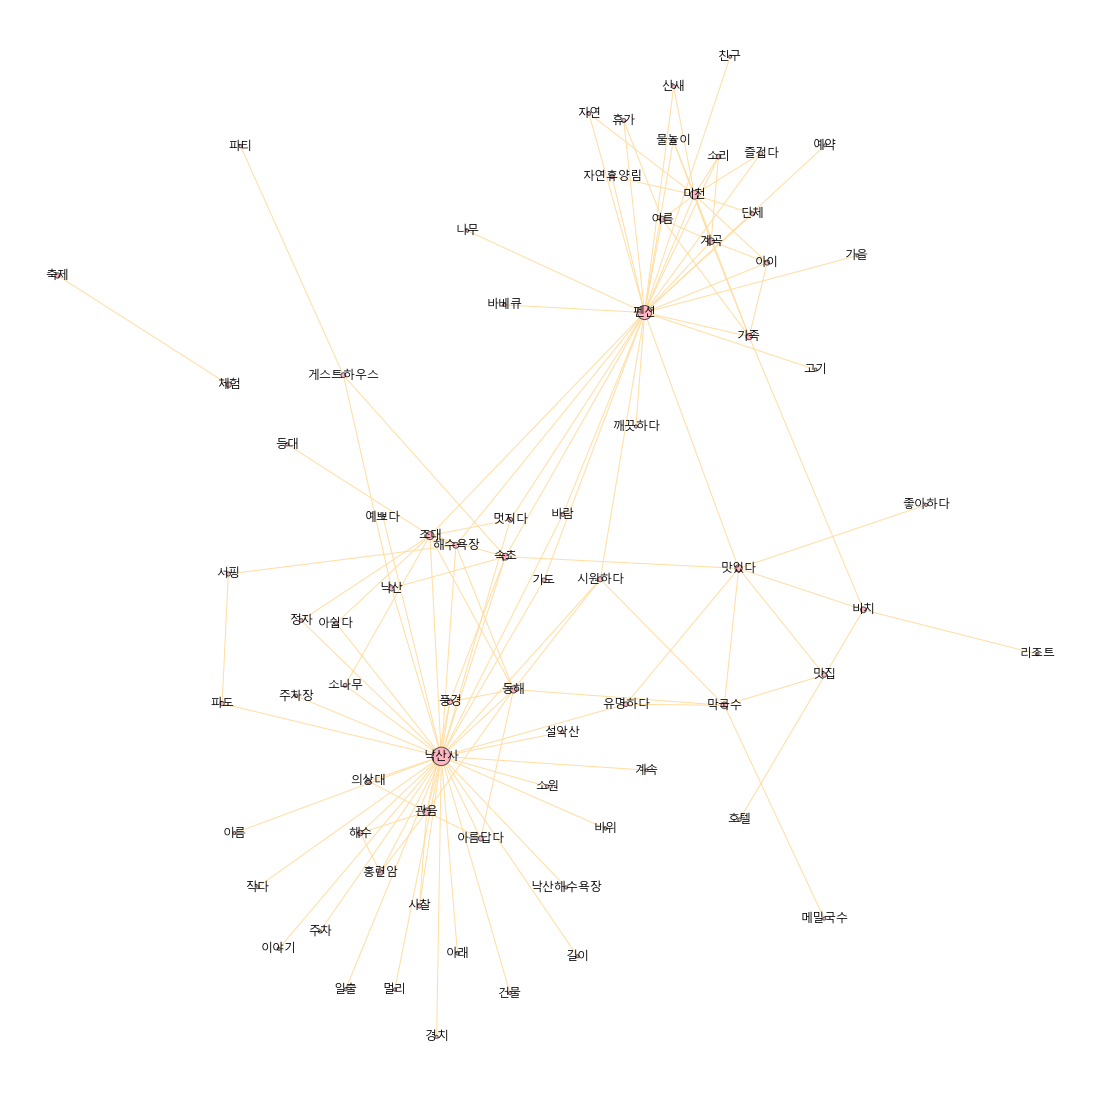

In [438]:
# 페이지 랭크
plt.figure(figsize= (15,15))
nx.draw(G,node_size=sizes, pos = nx.spring_layout(G, k=3.5, iterations= 100), **options, font_family=fontprop)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555")
# plt.savefig('양양_networkx.png')